# Equalizador Não-Linear com Redes Neurais para Sistema Óptico IM/DD

In [1]:
import numpy as np
from optic.torchUtils import slidingWindowDataSet, MLP
import torch
from torch import nn
from torch.utils.data import DataLoader
from torch.utils.data import Dataset, ConcatDataset
from optic.comm.modulation import GrayMapping, modulateGray, demodulateGray
from optic.dsp.core import pulseShape, lowPassFIR, pnorm, signal_power
from optic.utils import parameters, dBm2W
from optic.models.devices import mzm, photodiode, edfa
from optic.comm.modulation import GrayMapping, modulateGray, demodulateGray

from tqdm.notebook import tqdm
from commpy.utilities  import upsample
from optic.dsp.core import firFilter
from optic.models.channels import linearFiberChannel
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

import os
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'

In [3]:
import OpticFunctions as of
import RNNFunctions as rf
import importlib
import IPython.display as ipd

In [12]:
from IPython.core.display import HTML
from IPython.core.pylabtools import figsize

figsize(10, 3)

In [8]:
np.random.seed(seed=123)

# Geração do sinal para treinamento

In [9]:
SpS = 16  # Amostras por símbolo
M = 4              # Ordem do formato de modulação
Rs = 10e9          # taxa de símbolos

#Simulação do Sinal
sinaltx, symbtx = of.SimulaSinalOptico(SpS = SpS, M = M, Rs = Rs)

SymbTx antes da normalização:  [-1. -3. -3. ... -1. -3.  3.]


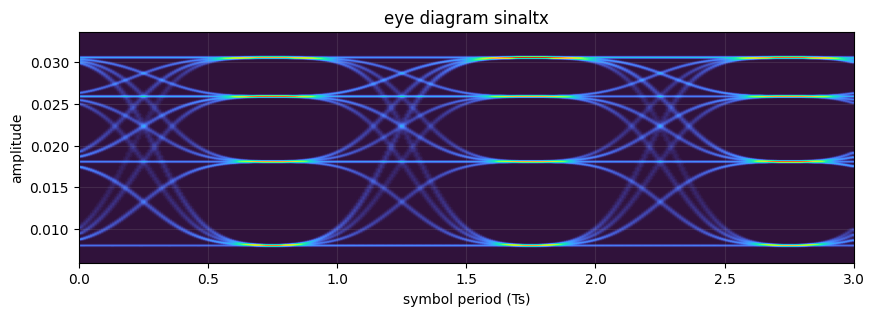

In [14]:
of.PlotEyediagram(sinaltx, SpS, label = 'sinaltx')

In [10]:
dist_fibra = 100

sinalrx = of.SimulaCanalOptico(sinal = sinaltx, Rs = Rs, SpS = SpS,  dist_fibra = dist_fibra)

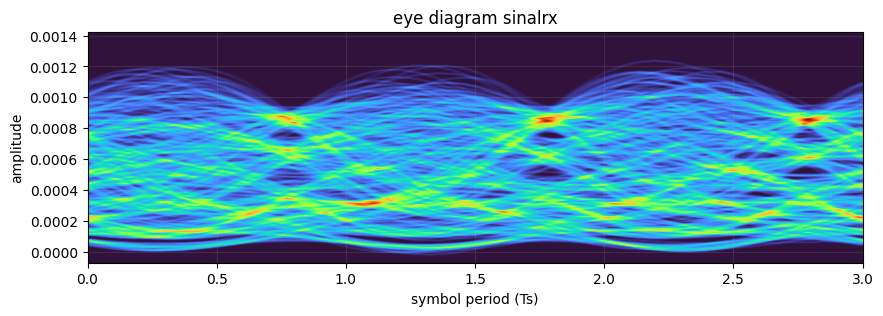

In [13]:
of.PlotEyediagram(sinalrx, SpS, label = 'sinalrx')

Number of counted errors = 32759 
BER = 1.64e-02 


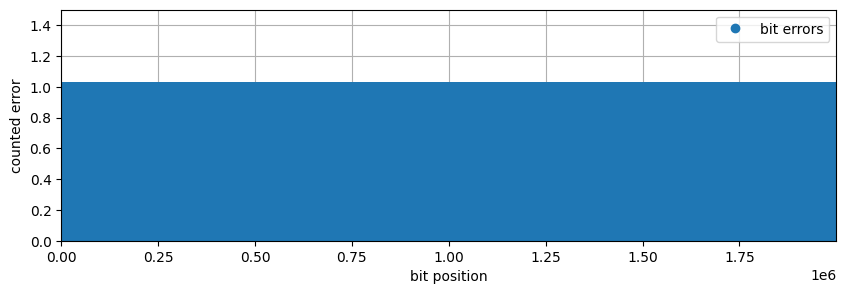

In [23]:
bitstx = of.RecuperaBits(sinal = sinaltx, SpS = SpS, M = M)
bitsrx = of.RecuperaBits(sinal = sinalrx, SpS = SpS, M = M)

of.CalculaBER(bitstx, bitsrx)

# Estruturação dos Dados para Treinamento

In [15]:
SpS_in = 16
Ntaps = 64
batch_size = 64
shuffle = True
shuffle_full = False

train_dataset, test_dataset, full_dataset = of.CriaDataSet(symb = symbtx, signal = sinalrx, SpS_in = SpS_in)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=shuffle)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=shuffle)

full_dataloader = DataLoader(full_dataset, batch_size=batch_size, shuffle=shuffle_full)

# Criação do Modelo

In [16]:
modelo = MLP([Ntaps, 50, 32, 16, 8, 4, 1])

## Definição dos Hiperparâmetros

In [17]:
loss = nn.MSELoss()
optimizer = torch.optim.Adam(modelo.parameters(), lr = 0.00011)
epochs = 10
cada_print = 5000

# Treinamento do Modelo

In [18]:
for t in range(epochs):
    print(f"Época {t+1}\n-------------------------------")
    of.train_loop(train_dataloader, modelo, loss, optimizer, cada_print)
    of.test_loop(test_dataloader, modelo, loss)
print("Pronto!")
framerate = 44100
t = np.linspace(0,1,framerate*1)
data = np.sin(2*np.pi*220*t) + np.sin(2*np.pi*224*t)
ipd.Audio(data,rate=framerate, autoplay=True)

Época 1
-------------------------------
loss: 1.266923[   64/800000]
loss: 0.013473[320064/800000]
loss: 0.008080[640064/800000]
Perda média: 0.005130 

Época 2
-------------------------------
loss: 0.005531[   64/800000]
loss: 0.005288[320064/800000]
loss: 0.001769[640064/800000]
Perda média: 0.001827 

Época 3
-------------------------------
loss: 0.001388[   64/800000]
loss: 0.000457[320064/800000]
loss: 0.000175[640064/800000]
Perda média: 0.000170 

Época 4
-------------------------------
loss: 0.000089[   64/800000]
loss: 0.000138[320064/800000]
loss: 0.000031[640064/800000]
Perda média: 0.000136 

Época 5
-------------------------------
loss: 0.000088[   64/800000]
loss: 0.000310[320064/800000]
loss: 0.000021[640064/800000]
Perda média: 0.000063 

Época 6
-------------------------------
loss: 0.000020[   64/800000]
loss: 0.000009[320064/800000]
loss: 0.000003[640064/800000]
Perda média: 0.000054 

Época 7
-------------------------------
loss: 0.000022[   64/800000]
loss: 0.00000

# Cálculo da BER do Sinal Equalizado

In [19]:
symbnn = of.GeraSinalEqualizado(modelo, full_dataloader)

Number of counted errors = 52 
BER = 2.60e-05 


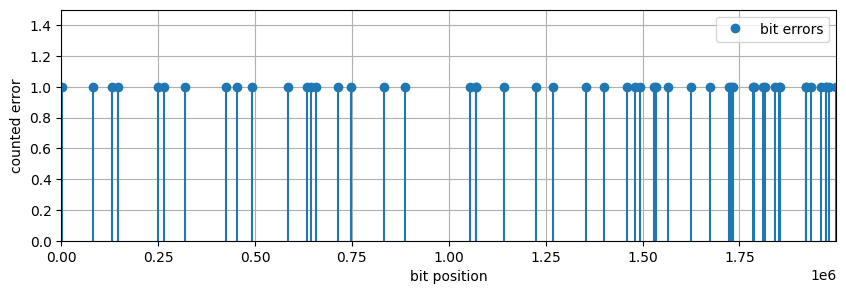

In [24]:
const = GrayMapping(M, 'pam') 
Es = signal_power(const)

bitsnn = demodulateGray(np.sqrt(Es)*pnorm(symbnn), M, 'pam')

of.CalculaBER(bitstx, bitsnn)

# Comparação entre a BER dos sinais equalizado e original em função da potência de entrada

In [25]:
discard = 100
power = np.arange(-15, 0)
BER = np.zeros(power.size)
BER_NN = np.zeros(power.size)
SpS_out = 1
Ntaps = 64

for ind, Pin in enumerate(power):
    sinaltx, symbtx = of.SimulaSinalOptico(SpS = SpS, Rs = Rs, M = M, Pi_dBm = Pin)
    
    irx = of.SimulaCanalOptico(sinaltx, SpS = SpS, Rs = Rs, dist_fibra = 100)
    
    bitsTx = of.RecuperaBits(sinaltx, SpS, M)
    bitsRx = of.RecuperaBits(irx, SpS, M)
    
    err = np.logical_xor(bitsRx[discard:bitsRx.size-discard], bitsTx[discard:bitsTx.size-discard])
    BER[ind] = np.mean(err)
    
    print('BER = %.2e '%(BER[ind]))
    
    signalrx = pnorm(irx[0::SpS//SpS_out])
    signalrx= (signalrx - np.mean(signalrx))/np.std(signalrx)
    
    dataset = slidingWindowDataSet(signalrx, symbtx, Ntaps, SpS_out)
    
    dataloader = DataLoader(dataset, batch_size=len(dataset), shuffle=False)

    modelo.eval()
    with torch.no_grad():
        for batch, (X, y) in enumerate(dataloader):
            X = X.float()
            pred = modelo(X)
            symbRx_NN = pred
            symbRx_NN = symbRx_NN.numpy().reshape(-1,)
    
    bitsRx_NN = demodulateGray(np.sqrt(Es)*pnorm(symbRx_NN), M, 'pam')

    #discard = 1000
    err = np.logical_xor(bitsRx_NN[discard:bitsRx_NN.size-discard], bitsTx[discard:bitsTx.size-discard])
    BER_NN[ind] = np.mean(err)

    #Pb = 0.5*erfc(Q/np.sqrt(2)) # theoretical error probability
    print('BER_NN = %.2e '%(BER_NN[ind]))

SymbTx antes da normalização:  [ 1. -1. -3. ... -3.  3. -1.]
BER = 1.55e-01 
BER_NN = 1.50e-01 
SymbTx antes da normalização:  [ 3. -3. -3. ... -3.  1. -1.]
BER = 1.33e-01 
BER_NN = 1.22e-01 
SymbTx antes da normalização:  [-3.  3.  3. ... -1. -1. -1.]
BER = 1.13e-01 
BER_NN = 9.67e-02 
SymbTx antes da normalização:  [ 3. -1.  3. ...  1. -1.  3.]
BER = 9.45e-02 
BER_NN = 7.35e-02 
SymbTx antes da normalização:  [-3.  3.  1. ... -3. -1. -1.]
BER = 7.91e-02 
BER_NN = 5.38e-02 
SymbTx antes da normalização:  [ 3. -3.  3. ... -3. -3.  3.]
BER = 6.61e-02 
BER_NN = 3.77e-02 
SymbTx antes da normalização:  [-1. -3. -1. ... -1.  1. -1.]
BER = 5.47e-02 
BER_NN = 2.49e-02 
SymbTx antes da normalização:  [-3. -1. -1. ... -1.  1.  3.]
BER = 4.57e-02 
BER_NN = 1.59e-02 
SymbTx antes da normalização:  [ 1. -3.  1. ... -3.  1.  1.]
BER = 3.80e-02 
BER_NN = 9.30e-03 
SymbTx antes da normalização:  [ 1. -1. -3. ... -3.  3. -3.]
BER = 3.22e-02 
BER_NN = 5.30e-03 
SymbTx antes da normalização:  [ 3. -3. 

Text(0, 0.5, 'log10(BER)')

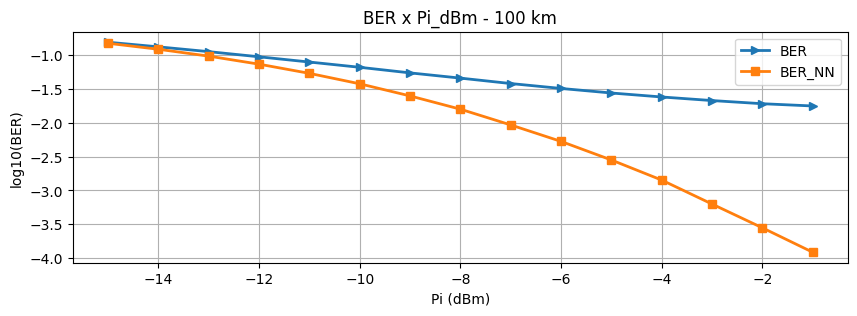

In [27]:
plt.plot(power, np.log10(BER),'>-', label='BER',linewidth = 2)
plt.plot(power, np.log10(BER_NN),'-s', label='BER_NN', linewidth = 2)
plt.grid()
plt.legend();
plt.title('BER x Pi_dBm - 100 km')
plt.xlabel('Pi (dBm)')
plt.ylabel('log10(BER)')